# `app.py`

In [16]:
%matplotlib inline

In [1]:
import os
import sys
import collections
import pandas as pd
import mudata

sys.path.append("/cellar/users/aklie/opt/gene_program_evaluation/dashapp")
from utils import load_config
from parse import parse

def load_and_parse_data(
    path_mdata,
    path_evaluation_outs,
    data_key="rna",
):
    try:
        
        # Load mdata
        mdata = mudata.read_h5mu(path_mdata)
        mdata.mod = collections.OrderedDict(sorted(mdata.mod.items()))
        
        # Parse data
        results = parse(mdata, path_evaluation_outs, data_key)
        
        # Add obs data from data_key
        obs = mdata[data_key].obs.reset_index()
        obs.columns = ["barcode"] + list(obs.columns[1:])
        results["obs"] = obs
        
        # Add obsm data
        obsms = {}
        for obsm_key in mdata[data_key].obsm:
            cols = [f"{obsm_key}_{i}" for i in range(2)]
            rows = mdata[data_key].obs_names
            df = pd.DataFrame(mdata[data_key].obsm[obsm_key][:, :2], columns=cols, index=rows)
            obsms[obsm_key] = df
        results["obsms"] = obsms

        # Return results
        return results

    except Exception as e:
        print(f"Could not load mdata: {e}")
        sys.exit(1)

path_config = "/cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/bin/report/config/report.yaml"
config = load_config(path_config)

# Parse config for paths
path_evaluation_outs = config["path_evaluation_outs"]
path_mdata = config["path_mdata"]
path_evaluation_config = config["path_evaluation_config"]
path_report_out = config["path_report_out"]

# Parse config for other parameters
data_key = config["data_key"]
categorical_keys = config["categorical_keys"] if config["categorical_keys"] else []
continuous_keys = config["continuous_keys"] if config["continuous_keys"] else []
annotations_loc = config["annotations_loc"]

# Load evaluation config
evaluation_config = load_config(path_evaluation_config)

# Load and parse data
results = load_and_parse_data(
    path_mdata=path_mdata,
    path_evaluation_outs=path_evaluation_outs,
    data_key=data_key,
)

# Add in path_report_out to results
results['path_evaluation_outs'] = path_evaluation_outs
results['path_mdata'] = path_mdata
results['evaluation_config'] = evaluation_config
results['path_report_out'] = path_report_out
results['data_key'] = data_key
results['categorical_keys'] = categorical_keys
results['continuous_keys'] = continuous_keys
results['annotations_loc'] = annotations_loc

# `programs_summary.py`

## Covariate association

In [68]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from dash import html
import io
import base64
from plot import scatterplot
from utils import map_categories_to_colors

In [69]:
def scatterplot(
    data: pd.DataFrame,
    x_column: str,
    y_column: str,
    title: str,
    sorted: bool = True,
    x_axis_title: str = None,
    y_axis_title: str = None,
    cumulative: bool = False,
    show_xaxis_labels: bool = False,
    colors: list = None,  # New parameter for optional colors
    size: int = 1
):
    """Create a scatter plot layout in Dash using Plotly.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the data for the plot.
    x_column : str
        The column to use for the x-axis.
    y_column : str
        The column to use for the y-axis.
    title : str
        Title of the plot.
    x_axis_title : str, optional
        Title for the x-axis.
    y_axis_title : str, optional
        Title for the y-axis.
    cumulative : bool, optional
        Whether to plot cumulative values.
    show_xaxis_labels : bool, optional
        Whether to show labels on the x-axis.
    colors : list, optional
        List of colors corresponding to each point in the plot.

    Returns
    -------
    go.Figure
        A Plotly Figure containing the scatter plot.
    """
    # Compute cumulative values
    if cumulative:
        data[y_column] = data[y_column].cumsum()

    # Sort
    x_data = data.sort_values(y_column, ascending=cumulative)[x_column] if sorted else data[x_column]
    y_data = data.sort_values(y_column, ascending=cumulative)[y_column] if sorted else data[y_column]

    # Plot
    fig = go.Figure(
        data=go.Scattergl(
            x=x_data,
            y=y_data,
            mode='markers',
            marker=dict(
                color=colors if colors is not None else 'blue',  # Use passed colors or default to blue
                size=size
            )
        )
    )

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title=x_axis_title if x_axis_title else x_column,
        yaxis_title=y_axis_title if y_axis_title else y_column,
        xaxis=dict(showticklabels=show_xaxis_labels),
        plot_bgcolor='rgba(0,0,0,0)',  # Transparent background
    )
    
    return fig

In [70]:
def scatterplot_static(
    data: pd.DataFrame,
    x_column: str,
    y_column: str,
    title: str,
    sorted: bool = True,
    x_axis_title: str = None,
    y_axis_title: str = None,
    cumulative: bool = False,
    show_xaxis_labels: bool = False,
    show_yaxis_labels: bool = False,
    colors: list = None,  # New parameter for optional colors
    cmap: str = None,
    size: int = 1,
    save_as_base64: bool = False
):
    """Generate a static scatter plot using Matplotlib."""

    # Compute cumulative values
    if cumulative:
        data[y_column] = data[y_column].cumsum()

    # Sort
    x_data = data.sort_values(y_column, ascending=cumulative)[x_column] if sorted else data[x_column]
    y_data = data.sort_values(y_column, ascending=cumulative)[y_column] if sorted else data[y_column]

    # Plot
    fig, ax = plt.subplots()
    scatter = ax.scatter(
        x_data,
        y_data,
        c=colors,
        s=size,
        cmap=cmap
    )

    if cmap:
        fig.colorbar(scatter, ax=ax)

    # remove the top and right spines from plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(x_axis_title if x_axis_title else x_column)
    ax.set_ylabel(y_axis_title if y_axis_title else y_column)
    ax.set_title(title)
    if not show_xaxis_labels:
        ax.set_xticks([])
    if not show_yaxis_labels:
        ax.set_yticks([])
    
    # Save the plot to a BytesIO object
    if save_as_base64:
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        
        # Encode the plot as a base64 string
        img_base64 = base64.b64encode(buf.read()).decode('ascii')
        
        return f"data:image/png;base64,{img_base64}"
    
    else:
        return fig

In [72]:
# Grab ish
selected_covariate = "sample"
selected_dim_reduction = "X_umap"
size = 1
debug = True
static = True

Selected dim reduction: X_umap, selected covariate: sample
Categorical covariate: sample
Colors: ['#393b79', '#393b79', '#393b79', '#393b79', '#393b79']
Color map: {'D0': '#393b79', 'sample_D1': '#b5cf6b', 'sample_D2': '#ad494a', 'sample_D3': '#de9ed6'}


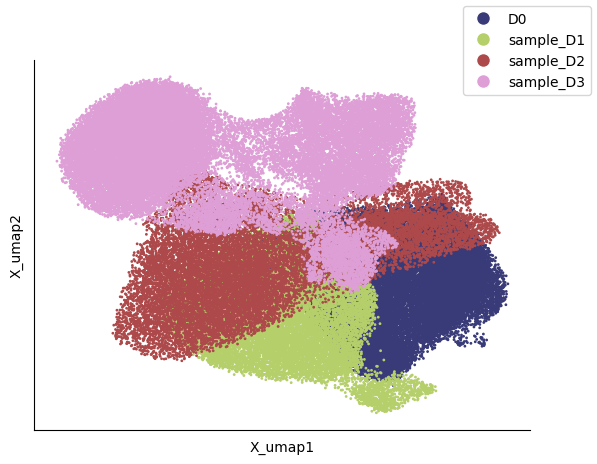

In [76]:
if debug:
    print(f"Selected dim reduction: {selected_dim_reduction}, selected covariate: {selected_covariate}")

# grab cell metadata
cell_metadata = results["obs"]

# Extract the relevant data for plotting (they will be selected_dim_reduction_0 and selected_dim_reduction_1)
data = obsms[selected_dim_reduction][[f'{selected_dim_reduction}_0', f'{selected_dim_reduction}_1']].loc[cell_metadata["barcode"]]
data.columns = ['X', 'Y']

# Add the selected covariate to the data
data[selected_covariate] = cell_metadata[selected_covariate].values

# Get covariate categories to more colors
if selected_covariate in categorical_keys:
    colors = categorical_key_colors[selected_covariate]
    categorical_color_map = categorical_key_color_maps[selected_covariate]
    continuous_color_map = None
    if debug:
        print(f"Categorical covariate: {selected_covariate}")
        print(f"Colors: {colors[:5]}")
        print(f"Color map: {categorical_color_map}")
else:
    colors = data[selected_covariate]
    categorical_color_map = None
    continuous_color_map = None
    if debug:
        print(f"Continuous covariate: {selected_covariate}")
        print(f"Colors: {colors[:5]}")
        print(f"Color map: {continuous_color_map}")

if static:
    fig = scatterplot_static(
        data=data,
        x_column="X",
        y_column="Y",
        sorted=False,
        title='',
        x_axis_title=f'{selected_dim_reduction}1',
        y_axis_title=f'{selected_dim_reduction}2',
        colors=colors,
        cmap=continuous_color_map,
        size=size,
    )

    # add legend to the plot
    if selected_covariate in categorical_keys:
        fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in categorical_color_map.items()])

else:
    
    # Plot using dynamic plotly function
    fig = scatterplot(
        data=data,
        x_column="X",
        y_column="Y",
        sorted=False,
        title='',
        x_axis_title=f'{selected_dim_reduction}1',
        y_axis_title=f'{selected_dim_reduction}2',
        colors=colors,
        size=1
    )

In [77]:
evaluation_config

{'io': {'path_mdata': '/cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/inference/iPSC_EC/cNMF_30_0.2_gene_names.h5mu',
  'path_out': '/cellar/users/aklie/opt/gene_program_evaluation/dashapp/examples/evaluation/iPSC_EC/cNMF_30',
  'data_key': 'rna',
  'prog_key': 'cNMF'},
 'categorical_association': {'categorical_key': 'sample',
  'pseudobulk_key': None,
  'test': 'dunn',
  'n_jobs': -1,
  'inplace': False},
 'perturbation_association': {'groupby_key': None,
  'collapse_targets': True,
  'pseudobulk': False,
  'reference_targets': ['non-targeting'],
  'n_jobs': -1,
  'inplace': False},
 'gene_set_enrichment': {'prog_nam': None,
  'organism': 'human',
  'library': ['Reactome_2022', 'GO_Biological_Process_2023'],
  'method': 'fisher',
  'database': 'enrichr',
  'loading_rank_thresh': 300,
  'n_jobs': -1,
  'inplace': False,
  'user_geneset': None,
  'max_size': 500,
  'min_size': 5},
 'trait_enrichment': {'gwas_data': '/cellar/users/aklie/opt/gene_program_evaluation/smk/r